In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import featuretools as ft
from woodwork.logical_types import Categorical

In [2]:
# load data

df = pd.read_csv("retail.csv", parse_dates=["invoice_date"])

df.head()

,customer_id,invoice,invoice_date,stock_code,description,quantity,price
0,13085.0,489434,2009-12-01 07:45:00,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95
1,13085.0,489434,2009-12-01 07:45:00,79323P,PINK CHERRY LIGHTS,12,6.75
2,13085.0,489434,2009-12-01 07:45:00,79323W,WHITE CHERRY LIGHTS,12,6.75
3,13085.0,489434,2009-12-01 07:45:00,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2.10
4,13085.0,489434,2009-12-01 07:45:00,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.25


In [3]:
df.tail()

,customer_id,invoice,invoice_date,stock_code,description,quantity,price
741296,15804.0,581585,2011-12-09 12:31:00,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,1.95
741297,13113.0,581586,2011-12-09 12:49:00,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2.95
741298,13113.0,581586,2011-12-09 12:49:00,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,1.25
741299,13113.0,581586,2011-12-09 12:49:00,21217,RED RETROSPOT ROUND CAKE TINS,24,8.95
741300,13113.0,581586,2011-12-09 12:49:00,20685,DOORMAT RED RETROSPOT,10,7.08


In [4]:
# number of customers

df["customer_id"].nunique()

5410

In [5]:
# number of invoices

df["invoice"].nunique() 

40505

In [6]:
# number of unique items

df["stock_code"].nunique()

4631

In [7]:
# total data

len(df)

741301

In [8]:
# create and entity set

es = ft.EntitySet(id="data")

In [9]:
# Add the data to the entity

es = es.add_dataframe(
    dataframe=df,              # the dataframe with the data
    dataframe_name="data",     # unique name to associate with this dataframe
    index="rows",              # column name to index the items
    make_index=True,           # if true, create a new column with unique values
    time_index="invoice_date", # column containing time data
    logical_types={
        "customer_id": Categorical, # the id is numerical, but should be handled as categorical
    },
)

# display the entity set
es

Entityset: data
  DataFrames:
    data [Rows: 741301, Columns: 8]
  Relationships:
    No relationships

In [10]:
# Create a new dataframe indicating its 
# relationship to the main data

# we start with invoice

es.normalize_dataframe(
    base_dataframe_name="data",     # Datarame name from which to split.
    new_dataframe_name="invoices",  # Name of the new dataframe.
    index="invoice",                # relationship will be created across this column.
    copy_columns=["customer_id"],   # columns to remove from base_dataframe and move to new dataframe.
)

# display the entity set
es

Entityset: data
  DataFrames:
    data [Rows: 741301, Columns: 8]
    invoices [Rows: 40505, Columns: 3]
  Relationships:
    data.invoice -> invoices.invoice

In [11]:
# Create a new dataframe indicating its 
# relationship to the previous dataframe

# now we work with customers

es.normalize_dataframe(
    base_dataframe_name="invoices",  # note that we use the df from the previous cell
    new_dataframe_name="customers",  # the name of the new df
    index="customer_id",             # the column that indicates the relationship
)

es

Entityset: data
  DataFrames:
    data [Rows: 741301, Columns: 8]
    invoices [Rows: 40505, Columns: 3]
    customers [Rows: 5410, Columns: 2]
  Relationships:
    data.invoice -> invoices.invoice
    invoices.customer_id -> customers.customer_id

In [12]:
# Create a new dataframe indicating its 
# relationship to the main data

# now we work with individual products

es.normalize_dataframe(
    base_dataframe_name="data",  # Datarame name from which to split.
    new_dataframe_name="items",  # Name of the new dataframe.
    index="stock_code",          # relationship will be created across this column.
)

# display the entity set
es

Entityset: data
  DataFrames:
    data [Rows: 741301, Columns: 8]
    invoices [Rows: 40505, Columns: 3]
    customers [Rows: 5410, Columns: 2]
    items [Rows: 4631, Columns: 2]
  Relationships:
    data.invoice -> invoices.invoice
    invoices.customer_id -> customers.customer_id
    data.stock_code -> items.stock_code

In [13]:
# the original data

es["data"].shape

(741301, 8)

In [14]:
# the original data

es["data"].head()

,rows,customer_id,invoice,invoice_date,stock_code,description,quantity,price
0,0,13085.0,489434,2009-12-01 07:45:00,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95
1,1,13085.0,489434,2009-12-01 07:45:00,79323P,PINK CHERRY LIGHTS,12,6.75
2,2,13085.0,489434,2009-12-01 07:45:00,79323W,WHITE CHERRY LIGHTS,12,6.75
3,3,13085.0,489434,2009-12-01 07:45:00,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2.10
4,4,13085.0,489434,2009-12-01 07:45:00,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.25


In [15]:
# the dataframe with invoice data

es["invoices"].shape

(40505, 3)

In [16]:
# the dataframe with invoice data

# note that featuretools automatically adds the column 
# with the first date detected for each invoice

es["invoices"].head()

,invoice,customer_id,first_data_time
489434,489434,13085.0,2009-12-01 07:45:00
489435,489435,13085.0,2009-12-01 07:46:00
489436,489436,13078.0,2009-12-01 09:06:00
489437,489437,15362.0,2009-12-01 09:08:00
489438,489438,18102.0,2009-12-01 09:24:00


In [17]:
# the customers dataframe

es["customers"].shape

(5410, 2)

In [18]:
# customers data

# note that featuretools automatically adds the column 
# with the date for the first invoice for each customer

es["customers"].head()

,customer_id,first_invoices_time
13085.0,13085.0,2009-12-01 07:45:00
13078.0,13078.0,2009-12-01 09:06:00
15362.0,15362.0,2009-12-01 09:08:00
18102.0,18102.0,2009-12-01 09:24:00
18087.0,18087.0,2009-12-01 09:43:00


In [19]:
# the products

es["items"].shape

(4631, 2)

In [20]:
# the products

# note that featuretools automatically adds the column 
# with the date for the first invoice for each product

es["items"].head()

,stock_code,first_data_time
85048,85048,2009-12-01 07:45:00
79323P,79323P,2009-12-01 07:45:00
79323W,79323W,2009-12-01 07:45:00
22041,22041,2009-12-01 07:45:00
21232,21232,2009-12-01 07:45:00


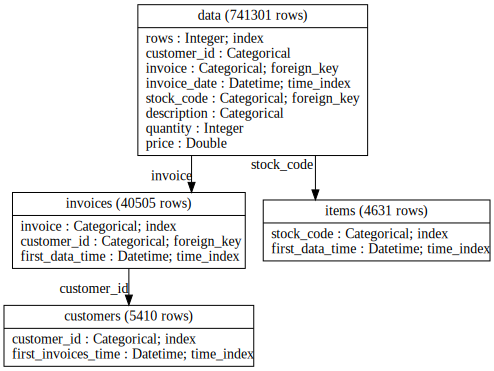

In [21]:
# display your EntitySet structure graphically

es.plot()

In [22]:
# Now we can start aggregating the data for each level.

# Let's begin with customers

feature_matrix, feature_defs = ft.dfs(
    entityset=es,                        # the entity set
    target_dataframe_name="customers",   # the dataframe for wich to create the features
    ignore_columns={                     # columns to ignore when creating features
        "invoices":["invoice"],
        "data":["customer_id"],
    }
)

print(len(feature_defs))

# display name of created features
feature_defs

114


[<Feature: COUNT(data)>,
 <Feature: MAX(data.price)>,
 <Feature: MAX(data.quantity)>,
 <Feature: MEAN(data.price)>,
 <Feature: MEAN(data.quantity)>,
 <Feature: MIN(data.price)>,
 <Feature: MIN(data.quantity)>,
 <Feature: MODE(data.description)>,
 <Feature: MODE(data.stock_code)>,
 <Feature: NUM_UNIQUE(data.description)>,
 <Feature: NUM_UNIQUE(data.stock_code)>,
 <Feature: SKEW(data.price)>,
 <Feature: SKEW(data.quantity)>,
 <Feature: STD(data.price)>,
 <Feature: STD(data.quantity)>,
 <Feature: SUM(data.price)>,
 <Feature: SUM(data.quantity)>,
 <Feature: DAY(first_invoices_time)>,
 <Feature: MONTH(first_invoices_time)>,
 <Feature: WEEKDAY(first_invoices_time)>,
 <Feature: YEAR(first_invoices_time)>,
 <Feature: MAX(invoices.COUNT(data))>,
 <Feature: MAX(invoices.MEAN(data.price))>,
 <Feature: MAX(invoices.MEAN(data.quantity))>,
 <Feature: MAX(invoices.MIN(data.price))>,
 <Feature: MAX(invoices.MIN(data.quantity))>,
 <Feature: MAX(invoices.NUM_UNIQUE(data.description))>,
 <Feature: MAX(in

In [23]:
# lets display 5 features for the book

feature_defs[5:10]

[<Feature: MIN(data.price)>,
 <Feature: MIN(data.quantity)>,
 <Feature: MODE(data.description)>,
 <Feature: MODE(data.stock_code)>,
 <Feature: NUM_UNIQUE(data.description)>]

In [24]:
# dataframe with the new features

feature_matrix.head()

,COUNT(data),MAX(data.price),MAX(data.quantity),MEAN(data.price),MEAN(data.quantity),MIN(data.price),MIN(data.quantity),MODE(data.description),MODE(data.stock_code),NUM_UNIQUE(data.description),...,SUM(invoices.MIN(data.price)),SUM(invoices.MIN(data.quantity)),SUM(invoices.NUM_UNIQUE(data.description)),SUM(invoices.NUM_UNIQUE(data.stock_code)),SUM(invoices.SKEW(data.price)),SUM(invoices.SKEW(data.quantity)),SUM(invoices.STD(data.price)),SUM(invoices.STD(data.quantity)),MODE(data.invoices.customer_id),NUM_UNIQUE(data.invoices.customer_id)
customer_id,,,,,,,,,,,,,,,,,,,,,
13085.0,92,830.12,48.0,12.413587,9.076087,0.55,-48.0,"RECORD FRAME 7"" SINGLE SIZE",22041,52,...,839.97,-3.0,92.0,92.0,5.121775,9.190325,18.102348,71.673954,13085.0,1
13078.0,855,12.75,300.0,3.961193,14.061988,0.19,-14.0,AREA PATROLLED METAL SIGN,82582,165,...,207.15,45.0,845.0,845.0,31.021187,92.081934,182.314131,1137.932892,13078.0,1
15362.0,40,9.95,48.0,3.612000,9.200000,0.21,1.0,BLUE PADDED SOFT MOBILE,20703,38,...,0.86,3.0,40.0,40.0,1.570870,1.976498,5.849501,18.242777,15362.0,1
18102.0,1068,3580.80,1008.0,10.831367,175.196629,0.27,-324.0,CREAM HEART CARD HOLDER,22189,415,...,7858.33,17709.0,1050.0,1050.0,77.785954,29.334878,216.812404,7368.950460,18102.0,1
18087.0,95,852.80,3906.0,11.971368,78.189474,0.36,-96.0,WHITE HANGING HEART T-LIGHT HOLDER,85123A,48,...,883.90,4162.0,95.0,95.0,7.420477,7.636412,32.169504,194.088519,18087.0,1


In [25]:
feature_matrix[feature_matrix.columns[5:10]].head()

,MIN(data.price),MIN(data.quantity),MODE(data.description),MODE(data.stock_code),NUM_UNIQUE(data.description)
customer_id,,,,,
13085.0,0.55,-48.0,"RECORD FRAME 7"" SINGLE SIZE",22041,52
13078.0,0.19,-14.0,AREA PATROLLED METAL SIGN,82582,165
15362.0,0.21,1.0,BLUE PADDED SOFT MOBILE,20703,38
18102.0,0.27,-324.0,CREAM HEART CARD HOLDER,22189,415
18087.0,0.36,-96.0,WHITE HANGING HEART T-LIGHT HOLDER,85123A,48


In [26]:
feature_matrix.shape

(5410, 114)

In [27]:
# We can now create features at invoice level

feature_matrix, feature_defs = ft.dfs(
    entityset=es,                      # the entity set
    target_dataframe_name="invoices",  # the dataframe for wich to create the features
    ignore_columns = {                 # columns to ignore when creating features
        "data": ["customer_id"],
    }, 
    max_depth = 1,
)

print(len(feature_defs))

# display name of created features
feature_defs

22


[<Feature: customer_id>,
 <Feature: COUNT(data)>,
 <Feature: MAX(data.price)>,
 <Feature: MAX(data.quantity)>,
 <Feature: MEAN(data.price)>,
 <Feature: MEAN(data.quantity)>,
 <Feature: MIN(data.price)>,
 <Feature: MIN(data.quantity)>,
 <Feature: MODE(data.description)>,
 <Feature: MODE(data.stock_code)>,
 <Feature: NUM_UNIQUE(data.description)>,
 <Feature: NUM_UNIQUE(data.stock_code)>,
 <Feature: SKEW(data.price)>,
 <Feature: SKEW(data.quantity)>,
 <Feature: STD(data.price)>,
 <Feature: STD(data.quantity)>,
 <Feature: SUM(data.price)>,
 <Feature: SUM(data.quantity)>,
 <Feature: DAY(first_data_time)>,
 <Feature: MONTH(first_data_time)>,
 <Feature: WEEKDAY(first_data_time)>,
 <Feature: YEAR(first_data_time)>]

In [28]:
# dataframe with the new features

feature_matrix.head()

,customer_id,COUNT(data),MAX(data.price),MAX(data.quantity),MEAN(data.price),MEAN(data.quantity),MIN(data.price),MIN(data.quantity),MODE(data.description),MODE(data.stock_code),...,SKEW(data.price),SKEW(data.quantity),STD(data.price),STD(data.quantity),SUM(data.price),SUM(data.quantity),DAY(first_data_time),MONTH(first_data_time),WEEKDAY(first_data_time),YEAR(first_data_time)
invoice,,,,,,,,,,,,,,,,,,,,,
489434,13085.0,8,6.95,48.0,4.081250,20.750000,1.25,10.0,WHITE CHERRY LIGHTS,21232,...,0.005779,1.609110,2.721205,12.646287,32.65,166.0,1,12,1,2009
489435,13085.0,4,3.75,24.0,2.625000,15.000000,1.65,12.0,CAT BOWL,22195,...,0.516958,2.000000,0.861684,6.000000,10.50,60.0,1,12,1,2009
489436,13078.0,19,8.50,24.0,3.730526,10.157895,1.25,2.0,PEACE WOODEN BLOCK LETTERS,21181,...,0.585934,0.484434,2.215269,5.899747,70.88,193.0,1,12,1,2009
489437,15362.0,23,9.95,12.0,3.628261,6.304348,0.65,1.0,BLUE PADDED SOFT MOBILE,10002,...,0.891079,0.465628,2.697424,4.149861,83.45,145.0,1,12,1,2009
489438,18102.0,17,6.40,60.0,2.591176,48.588235,0.98,28.0,CARROT CHARLIE+LOLA COASTER SET,20711,...,1.912915,-0.645841,1.540588,14.013649,44.05,826.0,1,12,1,2009


In [29]:
feature_matrix.shape

(40505, 22)

In [30]:
# Now we aggregate data at product level

feature_matrix, feature_defs = ft.dfs(
    entityset=es,                    # the entity set
    target_dataframe_name="items",   # the dataframe for wich to create the features
    ignore_columns = {               # columns to ignore when creating features
        "data": ["customer_id"]
    }, 
    verbose=True,
    max_depth = 1,
)

print(len(feature_defs))

# display name of created features
feature_defs

Built 21 features
Elapsed: 00:04 | Progress: 100%|██████████████████████████████████████████████████████████████████████████████████
21


[<Feature: COUNT(data)>,
 <Feature: MAX(data.price)>,
 <Feature: MAX(data.quantity)>,
 <Feature: MEAN(data.price)>,
 <Feature: MEAN(data.quantity)>,
 <Feature: MIN(data.price)>,
 <Feature: MIN(data.quantity)>,
 <Feature: MODE(data.description)>,
 <Feature: MODE(data.invoice)>,
 <Feature: NUM_UNIQUE(data.description)>,
 <Feature: NUM_UNIQUE(data.invoice)>,
 <Feature: SKEW(data.price)>,
 <Feature: SKEW(data.quantity)>,
 <Feature: STD(data.price)>,
 <Feature: STD(data.quantity)>,
 <Feature: SUM(data.price)>,
 <Feature: SUM(data.quantity)>,
 <Feature: DAY(first_data_time)>,
 <Feature: MONTH(first_data_time)>,
 <Feature: WEEKDAY(first_data_time)>,
 <Feature: YEAR(first_data_time)>]

In [31]:
feature_matrix.head()

,COUNT(data),MAX(data.price),MAX(data.quantity),MEAN(data.price),MEAN(data.quantity),MIN(data.price),MIN(data.quantity),MODE(data.description),MODE(data.invoice),NUM_UNIQUE(data.description),...,SKEW(data.price),SKEW(data.quantity),STD(data.price),STD(data.quantity),SUM(data.price),SUM(data.quantity),DAY(first_data_time),MONTH(first_data_time),WEEKDAY(first_data_time),YEAR(first_data_time)
stock_code,,,,,,,,,,,,,,,,,,,,,
85048,478,7.95,64.0,7.761715,4.677824,6.95,-12.0,15CM CHRISTMAS GLASS BALL 20 LIGHTS,525068,1,...,-1.599725,3.999000,0.391349,7.230611,3710.10,2236.0,1,12,1,2009
79323P,305,6.75,72.0,6.408361,4.173770,4.65,-61.0,PINK CHERRY LIGHTS,492813,1,...,-1.117316,0.662425,0.567605,14.070288,1954.55,1273.0,1,12,1,2009
79323W,429,6.75,48.0,6.377506,3.648019,4.25,-51.0,WHITE CHERRY LIGHTS,494669,2,...,-1.009456,0.161517,0.594396,12.283437,2735.95,1565.0,1,12,1,2009
22041,325,4.96,240.0,2.450000,21.587692,2.10,-24.0,"RECORD FRAME 7"" SINGLE SIZE",495886,1,...,4.379484,3.064706,0.376132,30.553270,796.25,7016.0,1,12,1,2009
21232,1984,2.46,504.0,1.238226,15.760585,1.06,-144.0,STRAWBERRY CERAMIC TRINKET BOX,523659,2,...,7.769322,5.533837,0.107221,30.344395,2456.64,31269.0,1,12,1,2009
